In [30]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

In [13]:
CONST = 4140e12 # s Hz^2 / (pc / cm^3)

def DM_delay(DM, freq):
    """
    Computes the frequency-dependent dispersion measure
    time delay.
    Inputs:
        - DM [pc*cm^-3]: dispersion measure
        - freq [Hz]: frequency
    Returns:
        - Pulse time delay in [s] 
    """
    return np.float32(DM * CONST) / freq**2

def make_frb(times, freqs, DM=332.72, pulse_width=2.12e-3, pulse_amp=0.5, t0=2e-3,
             dtype='float32', cdtype='complex64'):
    """
    Simulates a fast radio burst (FRB) observation given a 
    certain set of parameters.
    Inputs:
        - times [s]: integration times
        - freqs [Hz]: spectral frequencies
        - DM [pc*cm^-3]: dispersion measure
        - pulse_width [s]: width of FRB pulse
        - pulse_amp: amplitude of FRB pulse
        - t0 [s]: offset the pulse start time
    Returns:
        - Power matrix of shape (ntimes, nfreqs)
    """
    dt = times[1] - times[0]
    tmid = times[times.size // 2]
    delays = DM_delay(DM, freqs)
    delays -= tmid + delays[-1] - t0  # center lowest delay at t0

    # assume same inherent profile for all freqs
    pulse = pulse_amp * np.exp(-(times - tmid)**2 / (2 * pulse_width**2))
    _pulse = np.fft.rfft(pulse).astype(cdtype)
    _ffreq = np.fft.rfftfreq(pulse.size, dt)
    phs = np.exp(-2j * np.pi * np.outer(_ffreq.astype(dtype), delays.astype(dtype)))
    _pulse_dly = np.einsum('i,ij->ij', _pulse, phs)
    return np.fft.irfft(_pulse_dly, axis=0).astype(dtype)

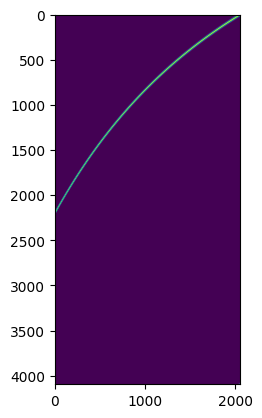

In [35]:
times = np.linspace(0, 1, NTIMES)
freqs = np.linspace(1.150e9, 1.650e9, NFREQ)
plt.imshow(make_frb(times, freqs))

In [14]:
fsamp = 1e9 # Hz
NFREQ = 2048
COARSE_ACC = 16
t_spec = 2 * NFREQ / fsamp * COARSE_ACC
t_file = 1 # s
ntimes = t_file / t_spec
print(int(round(ntimes)))

15259


In [56]:
#NTIMES = 16384
NTIMES = 4096
NFREQ = 2048
DM = 350
times = np.linspace(0, 1, NTIMES)
freqs = np.linspace(1.150e9, 1.650e9, NFREQ)
profile = make_frb(times, freqs, DM=DM, pulse_width=0.12e-3, pulse_amp=100, t0=10*80e-4)
profile += np.random.normal(size=profile.shape, loc=10)
# profile[:,::137] = 0  # blank out rfi
# profile[:,300:500] = 0  # blank out rfi
# profile[::519] = 100  # rfi
profile -= np.mean(profile, axis=0, keepdims=True)
print(profile.dtype)
print(profile.shape)
print(profile.strides)

float32
(4096, 2048)
(4, 16384)


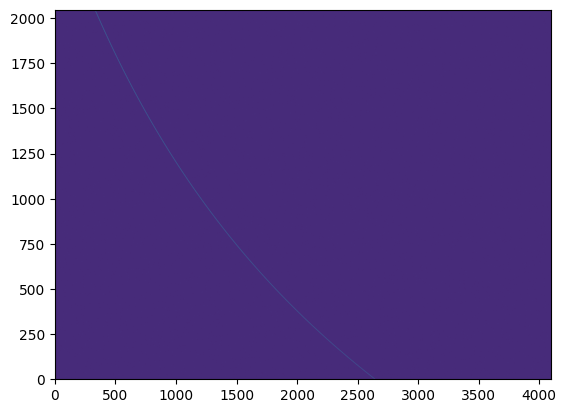

In [57]:
plt.figure()
plt.imshow(profile.T, aspect='auto', origin='lower')
# plt.imshow(np.abs(np.fft.ifft(np.fft.fft(profile, axis=0), axis=1)), aspect='auto', interpolation='nearest')
plt.show()

In [48]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [19]:
%load_ext cython

In [35]:
#%%cython -a
#import numpy as np
#cimport numpy as np
#import cython
#
#@cython.boundscheck(False)
#@cython.wraparound(False)
#@cython.cdivision(True) 
#def phs_sum(np.ndarray [np.complex64_t, ndim=2] d,
#            np.ndarray [np.complex64_t, ndim=2] p,
#            int stage):
#    cdef int i, j, nphs, off
#    cdef float complex buf1, buf2
#    for i in range(d.shape[0]):
#        for j in range(d.shape[1]):
#            if (j >> (stage - 1)) & 1 == 0:
#                off = j + (1 << (stage - 1))
#                buf1 = d[i, j] + d[i, off]
#                buf2 = p[i, j % p.shape[1]] * d[i, j] + p[i, off % p.shape[1]] * d[i, off]
#                d[i, j] = buf1
#                d[i, off] = buf2
#    return

In [58]:
%%cython
import numpy as np
cimport numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
def phs_sum(np.ndarray [np.complex64_t, ndim=2] d,
            np.ndarray [np.complex64_t, ndim=2] p):
    cdef int i, j
    cdef float complex buf1, buf2
    for i in range(d.shape[0]):
        for j in range(0, d.shape[1], 2):
            buf1 = d[i, j] + d[i, j + 1]
            buf2 = p[i, j] * d[i, j] + p[i, j + 1] * d[i, j + 1]
            d[i, j] = buf1
            d[i, j + 1] = buf2
    return

In [59]:
from numpy.fft import rfft, irfft
#from pyfftw.interfaces.numpy_fft import rfft, irfft

#def bit_reverse_count(nstages):
#    cnt = np.arange(2**nstages, dtype='uint32')
#    ans = np.zeros(2**nstages, dtype='uint32')
#    for i in range(nstages):
#        ans = (ans << 1) + (cnt & 1)
#        cnt = cnt >> 1
#    return ans

class FDMT:
    def __init__(self, freqs, times, maxDM=500, dtype='float32', cdtype='complex64'):
        self.cache = {}
        self.dtype = dtype
        self.cdtype = cdtype
        self.nfreqs = freqs.size
        self.ntimes = times.size
        _ffreq = np.fft.rfftfreq(self.ntimes, times[1] - times[0]).astype(dtype)
        self.stages = int(np.log2(self.nfreqs))
        chans = np.arange(self.nfreqs, dtype='uint32')
        freqs = freqs.astype(dtype)
        for i in range(1, self.stages):
            delays = DM_delay(maxDM / 2**i, freqs) - DM_delay(maxDM / 2**i, freqs[-1])
            phs = np.exp(2j * np.pi * np.outer(_ffreq, delays))
            freqs = (freqs[0::2] + freqs[1::2]) / 2
            self.cache[i] = phs.astype(cdtype)
            
    def phs_sum(self, d, phs):
        phs_sum(d, phs)
        return [d[:,0::2], d[:,1::2]]
            
    def apply(self, profile):
        self._data = rfft(profile, axis=0).astype(self.cdtype)
        ans = [self._data]
        for i in range(1, self.stages):
            ans = sum([self.phs_sum(d, self.cache[i]) for d in ans], [])
        return np.concatenate([irfft(d, axis=0) for d in ans], axis=1)
            
#def fdmt_homebrew(profile, freqs, times, maxDM=500, dtype='float32', cdtype='complex64'):
#    _ffreq = np.fft.rfftfreq(times.size, times[1] - times[0]).astype(dtype)
#    _data = np.fft.rfft(profile, axis=0).astype(cdtype)
#    stages = int(np.log2(freqs.size))
#    chans = np.arange(freqs.size, dtype='uint32')
#    freqs = freqs.astype(dtype)
#    for i in range(1, stages):
#        delays = DM_delay(maxDM / 2**i, freqs) - DM_delay(maxDM / 2**i, freqs[-1])
#        cache[i, maxDM] = phs = np.exp(2j * np.pi * np.outer(_ffreq, delays))
#        phs_data = phs[:,chans] * _data
#        ind = (chans & 1).astype(bool)  # first chan is in ~ind
#        chans >>= 1
#        _data[:,~ind], _data[:,ind] = _data[:,~ind] + _data[:,ind], phs_data[:,~ind] + phs_data[:,ind]
#        freqs = (freqs[0::2] + freqs[1::2]) / 2
#    br_chans = bit_reverse_count(stages)
#    return np.fft.irfft(_data[:,br_chans], axis=0).astype(dtype)

In [60]:
fdmt = FDMT(freqs, times)
data = fdmt.apply(profile)

In [61]:
print(data.shape)
maxDM = 500
t0, dm0 = inds = np.unravel_index(np.argmax(data, axis=None), data.shape)
print(times[t0], np.linspace(0, maxDM, NFREQ)[dm0])

(4096, 2048)
0.08034188034188035 350.02442598925256


In [24]:
def FDMT(Image, freqs, times, maxDM, maxDT=None, dtype='float'):
    assert (freqs.size, times.size) == Image.shape
    assert freqs.size == 2**np.around(np.log2(freqs.size))
    assert times.size == 2**np.around(np.log2(times.size))
    dt = times[1] - times[0]
    df = freqs[1] - freqs[0]
    full_dt = (freqs[0]**-2 - freqs[-1]**-2)
    maxDT = (DM_delay(maxDM, freqs[0]) - DM_delay(maxDM, freqs[-1])) / dt

    for i in range(int(np.log2(freqs.size))+1):
        delta_t = int(np.ceil(maxDT * ((freqs[0]**-2 - (freqs[0] + 2**i * df)**-2) / full_dt)))
        #print(i, delta_t)
        if i == 0:
            # State is nfreq x shifts x times
            State = np.zeros((freqs.size, delta_t+1, times.size), dtype)
            State[:,0,:] = Image  # zero bin has no shift
            for idt in range(1, delta_t+1):
                # XXX why is this State on the RHS and not Image
                State[:, idt, idt:] = State[:, idt-1, idt:] + Image[:, :-idt]
            continue
        # the maximum delta_t needed to calculate the ith iteration
        new_State = np.zeros((State.shape[0] // 2, delta_t+1, times.size), dtype)
        for ch in range(new_State.shape[0]):
            f0 = freqs[ch * 2**i]
            f2 = freqs[(ch + 1) * 2**i - 1]
            loc_dt = f0**-2 - f2**-2
            f1 = (f2 + f0) / 2
            delta_t_local = int(np.ceil(maxDT * (loc_dt / full_dt)))
            for idt in range(delta_t_local+1):
                dT1 = int(round(idt * (f0**-2 - f1**-2) / loc_dt))
                new_State[ch, idt] = State[2*ch, dT1]
                new_State[ch, idt, dT1:] += State[2*ch+1, idt - dT1, :times.size-dT1]
        State = new_State
    return State[0]

In [25]:
ans = FDMT(profile.T, freqs, times, maxDM)

In [26]:
%timeit fdmt.apply(profile)

936 ms ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit FDMT(profile.T, freqs, times, maxDM)

2.13 s ± 394 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


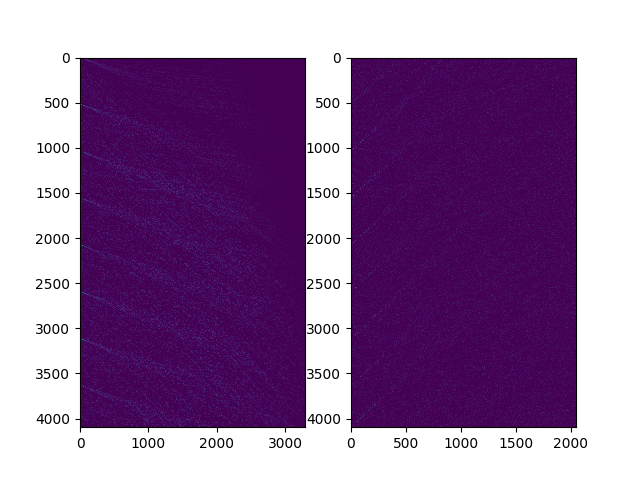

In [17]:
plt.figure()
plt.subplot(121)
plt.imshow(ans.T / ans.max(), aspect='auto', interpolation='nearest', vmin=0, vmax=0.5)
plt.subplot(122)
plt.imshow(data / data.max(), aspect='auto', interpolation='nearest', vmin=0, vmax=0.5)
#plt.xlim(0, 300)
#plt.ylim(0, 300)